## Prevendo a Intencão de Compras de Usuário usando SVM

## Importando os Pacotes

In [1]:
# Importando os pacotes
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Carga dos Dados

In [2]:
# Carregando os dados
df_original = pd.read_csv("online_shoppers_intention.csv")
df_original.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## Análise Exploratória

In [3]:
# Shape dos dados
df_original.shape

(12330, 18)

In [4]:
# Os tipos de dados
df_original.dtypes

Administrative             float64
Administrative_Duration    float64
Informational              float64
Informational_Duration     float64
ProductRelated             float64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

In [5]:
# Verificando se existe valores NaN
df_original.isnull().sum()

Administrative             14
Administrative_Duration    14
Informational              14
Informational_Duration     14
ProductRelated             14
ProductRelated_Duration    14
BounceRates                14
ExitRates                  14
PageValues                  0
SpecialDay                  0
Month                       0
OperatingSystems            0
Browser                     0
Region                      0
TrafficType                 0
VisitorType                 0
Weekend                     0
Revenue                     0
dtype: int64

In [6]:
# Removendo as linhas com valores ausentes
df_original.dropna(inplace=True)

In [7]:
# Aqui removemos todos os NaN
df_original.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [8]:
# Shape dos dados
df_original.shape

(12316, 18)

In [9]:
# Verificando valores unicos
df_original.nunique()

Administrative               27
Administrative_Duration    3336
Informational                17
Informational_Duration     1259
ProductRelated              311
ProductRelated_Duration    9552
BounceRates                1872
ExitRates                  4777
PageValues                 2704
SpecialDay                    6
Month                        10
OperatingSystems              8
Browser                      13
Region                        9
TrafficType                  20
VisitorType                   3
Weekend                       2
Revenue                       2
dtype: int64

Dividirei os dados em variáveis contínuas e categóricas, Trataremos todas as variáveis com menos de 30 entradas únicas como categóricas.

In [10]:
# Criar uma cópia do dataset original
df = df_original.copy()

# Lista de vazias para o resultado
continuous = []
categorical = []

# Loop pelas colunas
for c in df.columns[:-1]:
    if df.nunique()[c] >= 30:
        continuous.append(c)
    else:
        categorical.append(c)

In [11]:
continuous

['Administrative_Duration',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues']

In [12]:
# Variáveis contínuas
df[continuous].head()

,Administrative_Duration,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues
0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0
1,0.0,0.0,2.0,64.000000,0.00,0.10,0.0
2,-1.0,-1.0,1.0,-1.000000,0.20,0.20,0.0
3,0.0,0.0,2.0,2.666667,0.05,0.14,0.0
4,0.0,0.0,10.0,627.500000,0.02,0.05,0.0


In [13]:
# Variáveis contínuas
df[categorical].head()

,Administrative,Informational,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0.0,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False
1,0.0,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False
2,0.0,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False
3,0.0,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False
4,0.0,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True


## Gráficos para as variáveis numéricas.

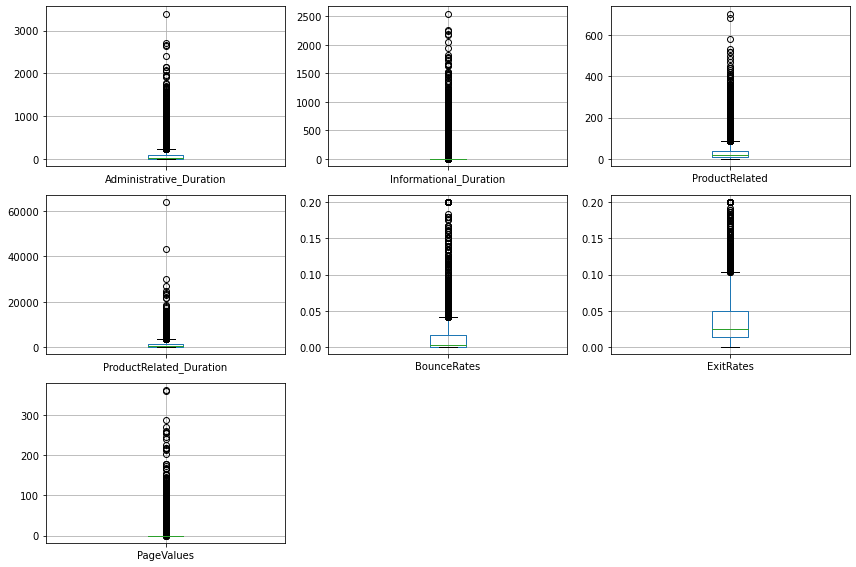

In [14]:
# Tamanho da área de plotagem
fig = plt.figure(figsize = (12,8))

# Loop pelas variáveis contínuas
for i, col in enumerate(continuous):
    plt.subplot(3,3, i + 1);
    df.boxplot(col)
    plt.tight_layout()

Variáveis contínuas parecem extremamente distorcidas. Vamos aplicar transformação de log para melhor visualização.

In [15]:
# Transformação de log nas variáveis contínuas
df[continuous] = np.log1p(1 + df[continuous])

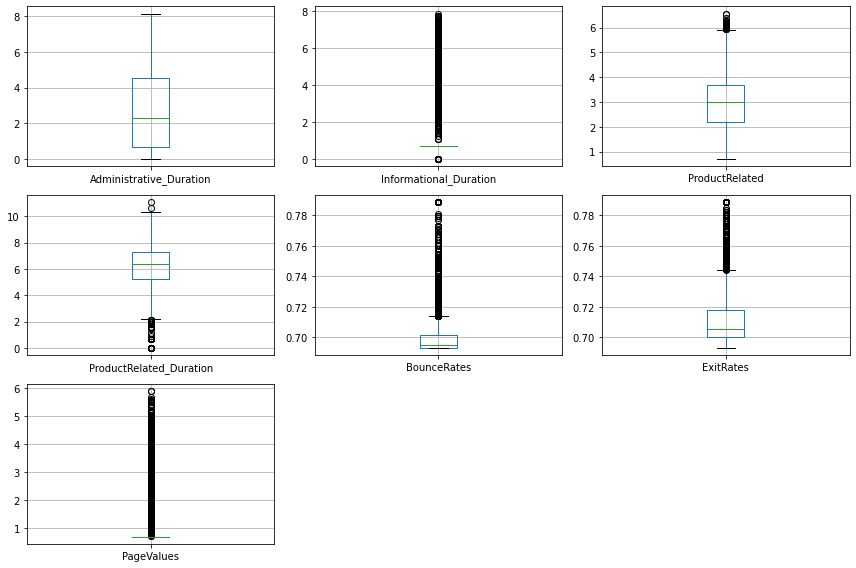

In [16]:
# Plot das variáveis contínuas

# Tamanho da área de plotagem
fig = plt.figure(figsize = (12,8))

# Loop pelas variaveis continuas
for i, col in enumerate(continuous):
    plt.subplot(3,3,i+1);
    df.boxplot(col);
    plt.tight_layout()

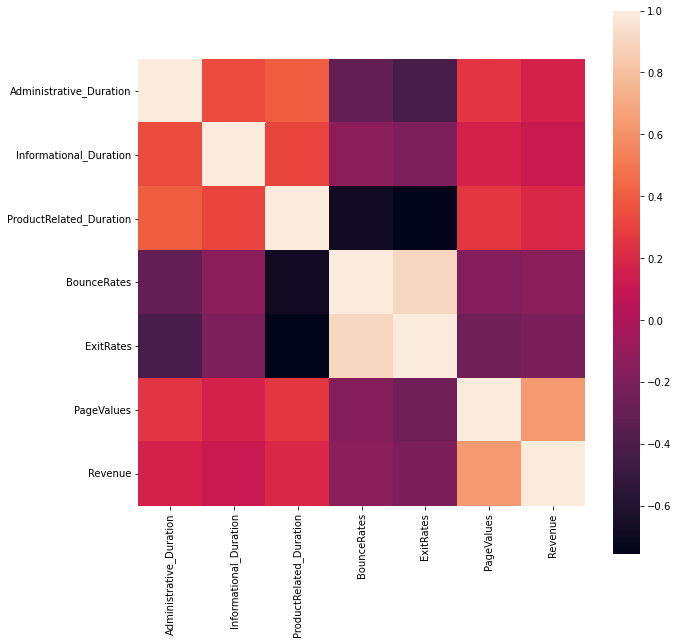

In [17]:
# Matriz de Correlação Entre Variáveis Contínuas.
# Área de plotagem
plt.figure(figsize = (10,10))

# Matriz de Correlação 
sns.heatmap(df[['Administrative_Duration',
                'Informational_Duration',  
                'ProductRelated_Duration',
                'BounceRates', 
                'ExitRates', 
                'PageValues',
                'Revenue']].corr(), vmax = 1., square = True)

### Visualização de gráficos de variáveis categóricas para analisar como a variável de destino é influenciada por elas.

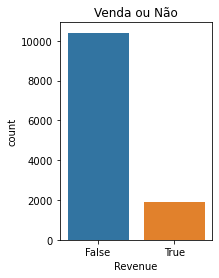

In [18]:
# Countplot Venda ou não
plt.subplot(1,2,2)
plt.title("Venda ou Não")
sns.countplot(df['Revenue'])

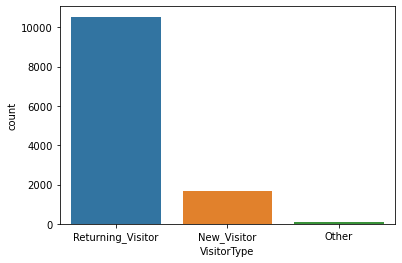

In [19]:
# Countplot tipo de Visitante
plt.xlabel("Tipo de Visitante")
sns.countplot(df['VisitorType'])

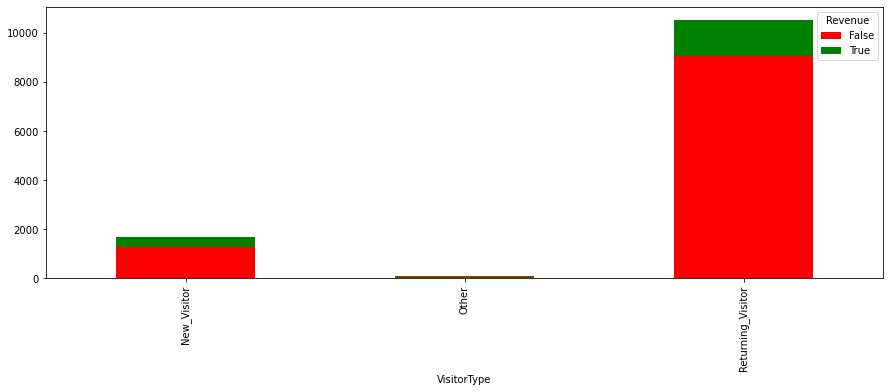

In [32]:
# Gráfico de bar Tipo de Visitante x Revenue
pd.crosstab(df["VisitorType"], df["Revenue"]).plot(kind = 'bar',
                                                  stacked = True,
                                                  figsize = (15,5),
                                                  color = ['red', 'green'])